In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import configparser
import pymongo

In [2]:
config = configparser.ConfigParser()
config.read('../database-dev/auth/config.ini')

MONGO_LOCAL = config.get('mongodb', 'MONGO_LOCAL')
MONGO_DB = config.get('mongodb', 'MONGO_DB')
client = pymongo.MongoClient(MONGO_LOCAL)
db = client.get_database(MONGO_DB)
collection = db['reps']

In [3]:
proj_dict = {
    'first_name': 1,
    'middle_name': 1,
    'last_name': 1,
    'dob': 1,
    'gender': 1,
    'current_party': 1,
    'state': 1,
    'roles': 1,
    'education': 1
}
results = collection.find({'in_office': True}, proj_dict)
df = pd.DataFrame(results)

In [4]:
from datetime import date

In [5]:
df['dob'] = df['dob'].map(lambda x: pd.to_datetime(x).date())

In [6]:
def get_age(dob):
    today = date.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    
    return age

In [7]:
df['age'] = np.vectorize(get_age)(df['dob'].values)

In [8]:
df['terms'] = np.vectorize(lambda x: len(x))(df['roles'])

In [9]:
df['education'] = df['education'].map(lambda x: x == None and [['HS', 'HS']] or x)
df['education'] = df['education'].map(lambda x: x == [] and [['HS', 'HS']] or x)

In [10]:
df['max_edu'] = df['education'].str[-1]

In [11]:
df['max_degree'] = df['max_edu'].str[0]
df['max_institution'] = df['max_edu'].str[1]

In [12]:
degree_dict = {
    'Bachelors': ['BS', 'BA', 'AB', 'BPA', 'BBA', 'ALB', 'LLB'],
    'Masters': [
        'MPA', 'MA', 'MSW', 'MS', 'MPP', 'MDIV', 'THM', 'MUP',
        'MHS', 'SYC', 'GRCERT', 'MPHIL', 'MIA', 'MSS', 'MPH',
        'MACC', 'MFA', 'MED'
    ],
    'Doctorate': ['PHD', 'DPA', 'EDD', 'PHARMD', 'DMIN', 'DPHIL', 'DVM'],
    'MBA': ['MBA'],
    'Medicine': ['MD', 'DPM'],
    'Nursing': ['GRDIP'],
    'Dental': ['DDS', 'DMD'],
    'Law': ['JD', 'LLM'],
    'HS': ['HS'],
    'Associates': ['AA', 'AAS', 'AS']
}

time_dict = {
    'Bachelors': 4,
    'Masters': 6,
    'Doctorate': 12,
    'MBA': 6,
    'Medicine': 10,
    'Nursing': 6,
    'Dental': 8,
    'Law': 7,
    'HS': 0,
    'Associates': 2
}

In [13]:
map_dict = {}
for k, vs in degree_dict.items():
    for v in vs:
        map_dict[v] = k

df['degree_group'] = df['max_degree'].map(lambda x: map_dict[x])
df['post_secondary'] = df['degree_group'].map(lambda x: time_dict[x])

In [69]:
data = pd.DataFrame(df.groupby('gender')['degree_group'].value_counts(normalize=True) * 100)
data.rename(columns={'degree_group': 'pct'}, inplace=True)
data.reset_index(inplace=True)

In [201]:
data

,gender,degree_group,pct
0,F,Bachelors,28.455285
1,F,Law,27.642276
2,F,Masters,24.390244
3,F,MBA,7.317073
4,F,Doctorate,5.691057
5,F,HS,3.252033
6,F,Medicine,1.626016
7,F,Associates,0.813008
8,F,Nursing,0.813008
9,M,Law,32.380952


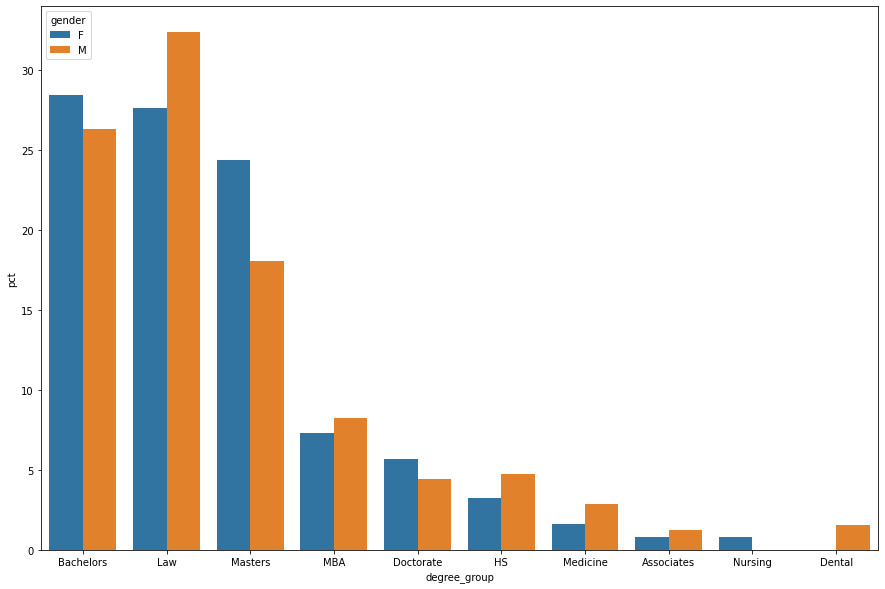

In [199]:
fig = plt.figure(figsize=(15,10))
sns.barplot(data=data, x='degree_group', y='pct', hue='gender')
plt.show()

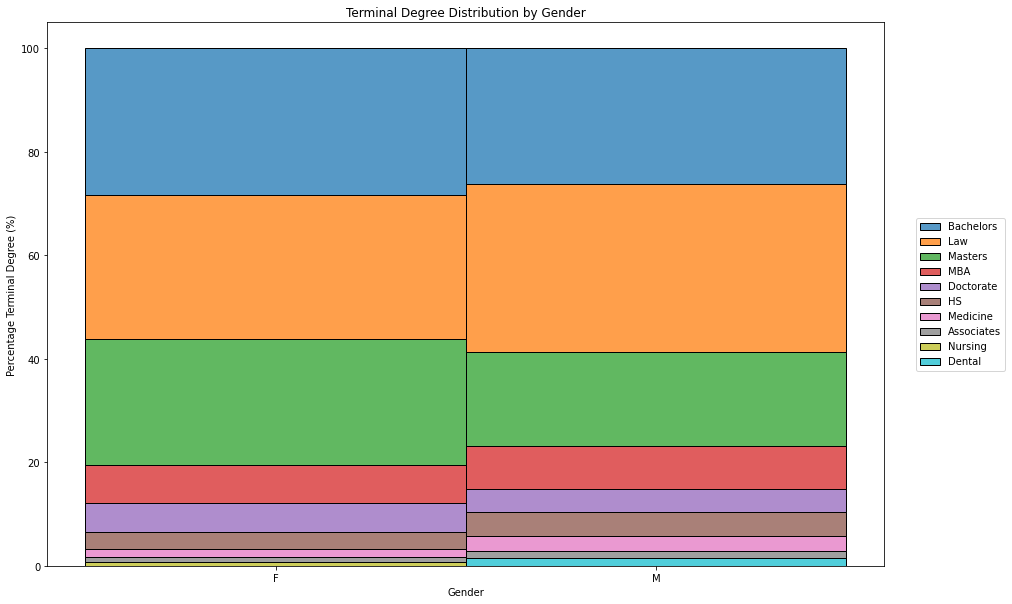

In [194]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
g = sns.histplot(data, x='gender', hue='degree_group', weights='pct', multiple='stack')
# plt.xticks(rotation=65)
plt.title('Terminal Degree Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage Terminal Degree (%)')
leg = g.get_legend()
plt.legend(leg.legendHandles, [ text.get_text() for text in leg.texts ], loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)

plt.show()